In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np

import tensorflow_probability.substrates.jax.distributions as tfd
from jax_moseq.utils.autoregression import random_rotation

from jax_moseq.models import twarhmm

from tqdm.auto import trange
import matplotlib.pyplot as plt

/Users/costacurta/jax-moseq/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_dict(d, depth=0, ind='  '):
    if type(d) != dict:
        try:
            item = d.shape
        except AttributeError:
            item = d
        print(f'{ind * depth}{item}')
        return
    
    for k, v in d.items():
        print(f'{ind * depth}{k}')
        print_dict(v, depth + 1, ind)

In [ ]:
# DATA GENERATION
# define model parameters
num_states = 5
num_sessions = 10
num_timesteps = 20000
emission_dim = 2
seed = jr.PRNGKey(23)
tau_list = jnp.array([1])

# weights + biases for starfish
keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

Ab = jnp.concatenate((weights - jnp.eye(2), biases[:,:,None]), axis=-1)
Q = covariances

# transitions
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
pi_z = transition_matrix
pi_t = jnp.array([[1]])

In [ ]:
num_trials = 20
zs, ts, xs = jax.vmap(twarhmm.generate.generate_states, in_axes=(0,None,None,None,None,None,None))(
    jr.split(seed, num_trials),
    pi_z, pi_t, Ab, Q, tau_list, num_timesteps
)

data = {'x': jax.device_put(xs),
        'mask': jax.device_put(jnp.ones_like(zs))} #TODO: get rid of masks

Text(0, 0.5, '$x_2$')

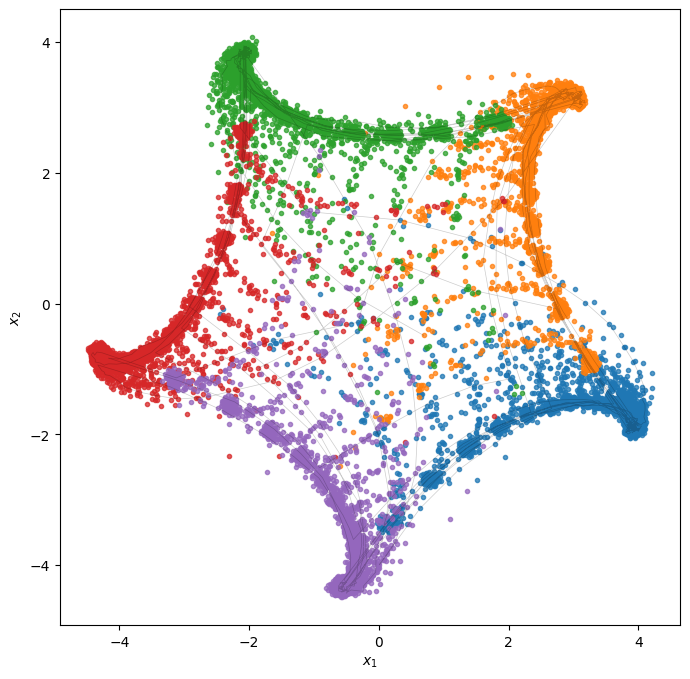

In [ ]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0][zs[0]==k].T, 'o',
         alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [ ]:
latent_dim = obs_dim = data['x'].shape[-1]
num_states = 10          # max number of states
nlags = 1                 # number of lags for AR dynamics
#TODO: get rid of nlags (must be 1)

trans_hypparams = {
    'gamma': 1e3,
    'alpha': 5.7,
    'kappa': 1e6,
    'num_states':num_states,
    't_stick': 0.95
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'nlags':  nlags,
    'latent_dim': latent_dim,
    'tau_list': jnp.array([1])
}

In [ ]:
model = twarhmm.init_model(data,
                         ar_hypparams=ar_hypparams,
                         trans_hypparams=trans_hypparams,
                         verbose=True)

print_dict(model)

TWARHMM: Initializing hyperparameters
TWARHMM: Initializing parameters
TWARHMM: Initializing states
seed
  (2,)
hypparams
  trans_hypparams
    gamma
      1000.0
    alpha
      5.7
    kappa
      1000000.0
    num_states
      10
    t_stick
      0.95
  ar_hypparams
    S_0_scale
      0.01
    K_0_scale
      10
    num_states
      10
    nlags
      1
    latent_dim
      2
    S_0
      (2, 2)
    K_0
      (3, 3)
    M_0
      (2, 3)
    nu_0
      4
params
  betas
    (10,)
  pi_z
    (10, 10)
  tau_list
    (1,)
  pi_t
    (1, 1)
  Ab
    (10, 2, 3)
  Q
    (10, 2, 2)
states
  z
    (20, 19999)
  t
    (20, 19999)


In [15]:
num_iters = 100    # number of training iterations

ll_keys = ['z', 'x']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    ll = twarhmm.model_likelihood(data, **model)
    model = twarhmm.resample_model(data, **model, states_only=False)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [17]:
def plot_ll(key, ll_history):
    plt.title(f'Log Likelihood of {key}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.plot(ll_history)
    plt.show()

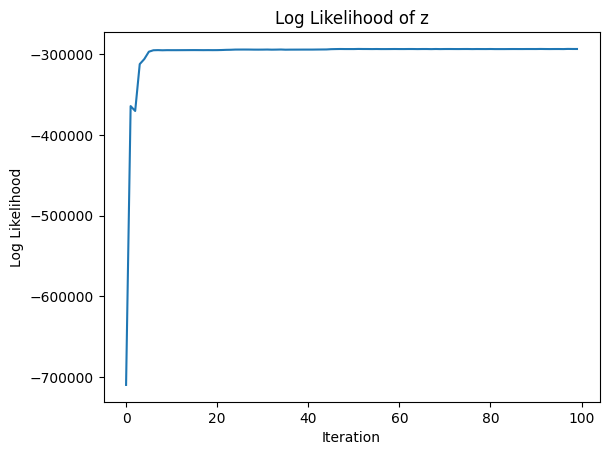

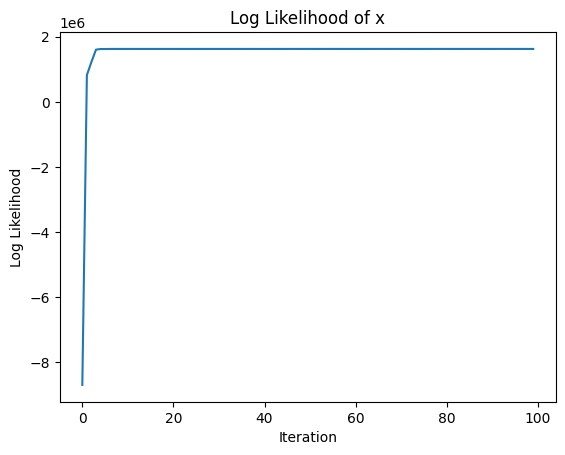

In [18]:
for k, v in ll_history.items():
    plot_ll(k, v)

Text(0, 0.5, '$x_2$')

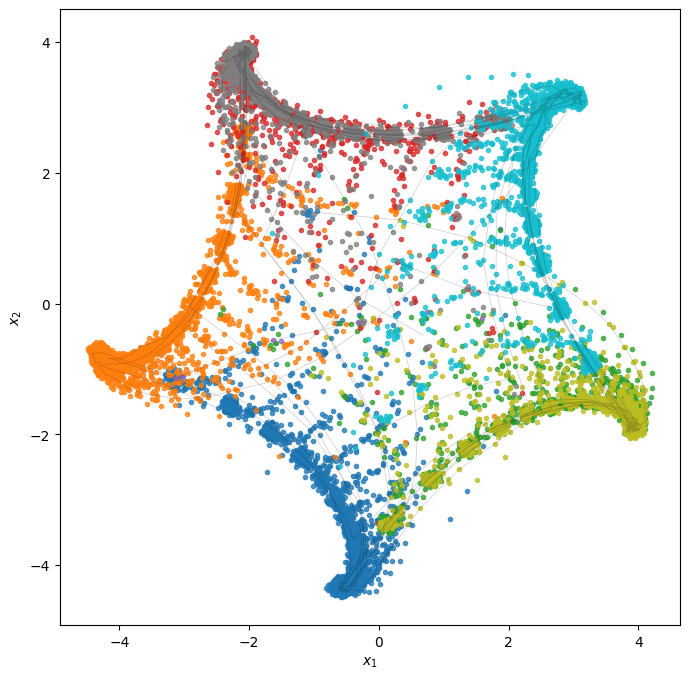

In [20]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0,1:][model['states']['z'][0]==k].T, 'o',
         alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

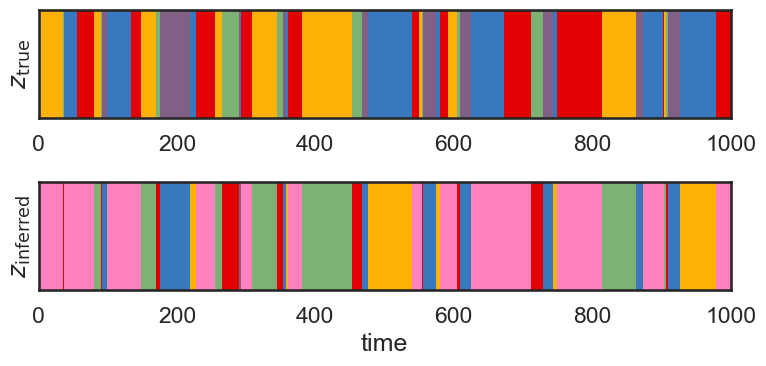

In [22]:
import seaborn as sns
from dynamax.utils.plotting import gradient_cmap

sns.set_style("white")
sns.set_context("talk")


color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

plot_slice = (0, 1000)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None, 0, ar_hypparams['nlags']:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(model['states']['z'][None,0,:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()